In [1]:
import numpy as np
import pandas as pd

import catboost as ctb
import category_encoders as ce
import shap
import xgboost as xgb
from scipy import stats
import seaborn as sns
from IPython.core.display import HTML

from scipy.stats import uniform


from sklearn.model_selection import train_test_split
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.metrics import recall_score, precision_score, roc_auc_score, accuracy_score, f1_score, roc_curve, auc
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC, LinearSVC, NuSVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis

from sklearn.metrics import confusion_matrix, plot_confusion_matrix, classification_report

from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import RandomizedSearchCV



from sklearn.preprocessing import LabelEncoder
import itertools

import matplotlib.pyplot as plt

%matplotlib inline


# load JS visualization code to notebook
shap.initjs()
import warnings
warnings.filterwarnings('ignore')


In [2]:
df = pd.read_csv("heart.csv")
print(df.shape)
df.head(3)

(303, 14)


,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1,1
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2,1
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2,1


In [3]:
df.dtypes

age           int64
sex           int64
cp            int64
trestbps      int64
chol          int64
fbs           int64
restecg       int64
thalach       int64
exang         int64
oldpeak     float64
slope         int64
ca            int64
thal          int64
target        int64
dtype: object

In [4]:
df.shape

(303, 14)

In [5]:
df = df[df['ca'] < 4] #drop the wrong ca values
df = df[df['thal'] > 0] # drop the wong thal value
print(f'The length of the data now is {len(df)} instead of 303!')

The length of the data now is 296 instead of 303!


In [6]:
df.shape

(296, 14)

In [7]:
df.rename(columns={'age': 'age', 'sex': 'sex', 'cp': 'chest_pain_type', 'trestbps': 'resting_blood_pressure', 'chol ': "cholesterol", 'fbs': "fasting_blood_sugar",
                   'restecg': "resting_electrocardiogram", 'thalach': 'max_heart_rate_achieved',
                   "exang":'exercise_induced_angina', 'oldpeak': 'st_depression', 'slope': 'st_slope', 
                   'ca': 'num_major_vessels', 'thal':'thalassemia', 'target': 'target'
                  }, inplace=True)

In [8]:
df.head(3)

,age,sex,chest_pain_type,resting_blood_pressure,chol,fasting_blood_sugar,resting_electrocardiogram,max_heart_rate_achieved,exercise_induced_angina,st_depression,st_slope,num_major_vessels,thalassemia,target
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1,1
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2,1
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2,1


In [9]:
df.describe()

,age,sex,chest_pain_type,resting_blood_pressure,chol,fasting_blood_sugar,resting_electrocardiogram,max_heart_rate_achieved,exercise_induced_angina,st_depression,st_slope,num_major_vessels,thalassemia,target
count,296.000000,296.000000,296.000000,296.00000,296.000000,296.00000,296.000000,296.000000,296.000000,296.000000,296.000000,296.000000,296.000000,296.000000
mean,54.523649,0.679054,0.959459,131.60473,247.155405,0.14527,0.523649,149.560811,0.327703,1.059122,1.395270,0.679054,2.327703,0.540541
std,9.059471,0.467631,1.034184,17.72662,51.977011,0.35297,0.526692,22.970792,0.470171,1.166474,0.618235,0.939726,0.585743,0.499198
min,29.000000,0.000000,0.000000,94.00000,126.000000,0.00000,0.000000,71.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
25%,48.000000,0.000000,0.000000,120.00000,211.000000,0.00000,0.000000,133.000000,0.000000,0.000000,1.000000,0.000000,2.000000,0.000000
50%,56.000000,1.000000,1.000000,130.00000,242.500000,0.00000,1.000000,152.500000,0.000000,0.800000,1.000000,0.000000,2.000000,1.000000
75%,61.000000,1.000000,2.000000,140.00000,275.250000,0.00000,1.000000,166.000000,1.000000,1.650000,2.000000,1.000000,3.000000,1.000000
max,77.000000,1.000000,3.000000,200.00000,564.000000,1.00000,2.000000,202.000000,1.000000,6.200000,2.000000,3.000000,3.000000,1.000000


In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 296 entries, 0 to 302
Data columns (total 14 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   age                        296 non-null    int64  
 1   sex                        296 non-null    int64  
 2   chest_pain_type            296 non-null    int64  
 3   resting_blood_pressure     296 non-null    int64  
 4   chol                       296 non-null    int64  
 5   fasting_blood_sugar        296 non-null    int64  
 6   resting_electrocardiogram  296 non-null    int64  
 7   max_heart_rate_achieved    296 non-null    int64  
 8   exercise_induced_angina    296 non-null    int64  
 9   st_depression              296 non-null    float64
 10  st_slope                   296 non-null    int64  
 11  num_major_vessels          296 non-null    int64  
 12  thalassemia                296 non-null    int64  
 13  target                     296 non-null    int64  

In [11]:
df['target'].value_counts()

1    160
0    136
Name: target, dtype: int64

## Feature Engineering

In [12]:
num_feats = ['age', 'cholesterol', 'resting_blood_pressure', 'max_heart_rate_achieved', 'st_depression', 'num_major_vessels']
bin_feats = ['sex', 'fasting_blood_sugar', 'exercise_induced_angina', 'target']
# caterorical (multi-)
nom_feats= ['chest_pain_type', 'resting_electrocardiogram', 'st_slope', 'thalassemia']
cat_feats = nom_feats + bin_feats

In [13]:
df.isnull().sum()

age                          0
sex                          0
chest_pain_type              0
resting_blood_pressure       0
chol                         0
fasting_blood_sugar          0
resting_electrocardiogram    0
max_heart_rate_achieved      0
exercise_induced_angina      0
st_depression                0
st_slope                     0
num_major_vessels            0
thalassemia                  0
target                       0
dtype: int64

In [14]:
num_feats = df.select_dtypes('number').drop(columns='target').columns

In [15]:
num_feats

Index(['age', 'sex', 'chest_pain_type', 'resting_blood_pressure', 'chol',
       'fasting_blood_sugar', 'resting_electrocardiogram',
       'max_heart_rate_achieved', 'exercise_induced_angina', 'st_depression',
       'st_slope', 'num_major_vessels', 'thalassemia'],
      dtype='object')

In [16]:
def label_encode_cat_features(df, cat_features):
    
    '''
    Given a dataframe and its categorical features, this function returns label-encoded dataframe
    '''
    
    label_encoder = LabelEncoder()
    df_encoded = df.copy()
    for col in cat_features:
        df_encoded[col] = label_encoder.fit_transform(df[col])
        df = df_encoded
        
        return df

def score_summary(names, classifiers):
    '''
    Given a list of classiers, this function calculates the accuracy, 
    ROC_AUC and Recall and returns the values in a dataframe
    '''
    
    cols=["Classifier", "Accuracy", "ROC_AUC", "Recall", "Precision", "F1"]
    data_table = pd.DataFrame(columns=cols)
    
    for name, clf in zip(names, classifiers):        
        clf.fit(X_train, y_train)
        
        pred = clf.predict(X_val)
        accuracy = accuracy_score(y_val, pred)

        pred_proba = clf.predict_proba(X_val)[:, 1]
        
        fpr, tpr, thresholds = roc_curve(y_val, pred_proba)        
        roc_auc = auc(fpr, tpr)
        # confusion matrix, cm
        
        cm = confusion_matrix(y_val, pred) 
        
        # recall: TP/(TP+FN)
        recall = cm[1,1]/(cm[1,1] +cm[1,0])
        
        # precision: TP/(TP+FP)
        precision = cm[1,1]/(cm[1,1] +cm[0,1])
        
        # F1 score: TP/(TP+FP)
        f1 = 2*recall*precision/(recall + precision)

        df = pd.DataFrame([[name, accuracy*100, roc_auc, recall, precision, f1]], columns=cols)
        data_table = data_table.append(df)     

    return(np.round(data_table.reset_index(drop=True), 2))


# def plot_confusion_matrix

In [17]:
cat_features = cat_feats
df = label_encode_cat_features(df, cat_features)

seed=0
test_size=0.25
features=df.columns[:-1]
X=df[features]
y=df['target']
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size = test_size, random_state=seed)



In [18]:
names = [
    'Logistic Regression',
    'Nearest Neighbors',
    'Support Vectors',
    'Nu SVC',
    'Decision Tree',
    'Random Forest',
    'AdaBoost',
    'Gradient Boosting',
    'Naive Bayes',
    'Linear DA',
    'Quadratic DA',
    "Neural Net"
]


classifiers = [
    LogisticRegression(solver="liblinear", random_state=seed),
    KNeighborsClassifier(2),
    SVC(probability=True, random_state=seed),
    NuSVC(probability=True, random_state=seed),
    DecisionTreeClassifier(random_state=seed),
    RandomForestClassifier(random_state=seed),
    AdaBoostClassifier(random_state=seed),
    GradientBoostingClassifier(random_state=seed),
    GaussianNB(),
    LinearDiscriminantAnalysis(),
    QuadraticDiscriminantAnalysis(),
    MLPClassifier(random_state=seed),
]


In [19]:

score_summary(names, classifiers).sort_values(by='Accuracy' , ascending = False)\
.style.background_gradient(cmap='coolwarm')\
.bar(subset=["ROC_AUC",], color='#6495ED')\
.bar(subset=["Recall"], color='#ff355d')\
.bar(subset=["Precision"], color='lightseagreen')\
.bar(subset=["F1"], color='gold')

,Classifier,Accuracy,ROC_AUC,Recall,Precision,F1
0,Logistic Regression,85.140000,0.940000,0.890000,0.820000,0.850000
9,Linear DA,85.140000,0.940000,0.890000,0.820000,0.850000
4,Decision Tree,83.780000,0.840000,0.800000,0.850000,0.820000
6,AdaBoost,83.780000,0.900000,0.860000,0.810000,0.830000
10,Quadratic DA,83.780000,0.920000,0.830000,0.830000,0.830000
11,Neural Net,83.780000,0.900000,0.940000,0.770000,0.850000
3,Nu SVC,81.080000,0.920000,0.910000,0.740000,0.820000
5,Random Forest,81.080000,0.920000,0.830000,0.780000,0.810000
8,Naive Bayes,81.080000,0.930000,0.830000,0.780000,0.810000
7,Gradient Boosting,78.380000,0.900000,0.830000,0.740000,0.780000


In [50]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform
from sklearn.model_selection import RepeatedStratifiedKFold


lr = LogisticRegression(tol=1e-4, max_iter=1000, random_state=seed)

space = dict(C=uniform(loc=0, scale=5),
                     penalty=['l2', 'l1'],
                     solver= ['liblinear'])

search = RandomizedSearchCV(lr, 
                         space, 
                         random_state=seed,
                         cv = 5, 
                         scoring='f1')

rand_search = search.fit(X_train, y_train)

print('Best Hyperparameters: %s' % rand_search.best_params_)


Best Hyperparameters: {'C': 0.2835648865872159, 'penalty': 'l2', 'solver': 'liblinear'}


In [51]:
params = rand_search.best_params_
lr = LogisticRegression(**params)
lr.fit(X_train, y_train)
print(classification_report(y_val, lr.predict(X_val)))

              precision    recall  f1-score   support

           0       0.89      0.82      0.85        39
           1       0.82      0.89      0.85        35

    accuracy                           0.85        74
   macro avg       0.85      0.85      0.85        74
weighted avg       0.85      0.85      0.85        74



In [20]:
from catboost import CatBoostClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from lightgbm import LGBMRegressor, LGBMClassifier, Booster
import lightgbm

names_boost =[
    'Catboost',
    'xgbbost',
    'light GBM'
]
classifiers = [
    CatBoostClassifier(random_state=seed, verbose=0),
    XGBClassifier(objective= 'binary:logistic', random_state=seed),
    LGBMClassifier(random_state=seed)
   ]

In [21]:
score_summary(names, classifiers).sort_values(by='Accuracy' , ascending = False)\
.style.background_gradient(cmap='coolwarm')\
.bar(subset=["ROC_AUC",], color='#6495ED')\
.bar(subset=["Recall"], color='#ff355d')\
.bar(subset=["Precision"], color='lightseagreen')\
.bar(subset=["F1"], color='gold')

,Classifier,Accuracy,ROC_AUC,Recall,Precision,F1
0,Logistic Regression,82.430000,0.920000,0.860000,0.790000,0.820000
2,Support Vectors,82.430000,0.920000,0.890000,0.780000,0.830000
1,Nearest Neighbors,81.080000,0.920000,0.830000,0.780000,0.810000


#### Parameter Tuning (RandomizedSearch): LGBMClassifie

In [22]:
rs_params = {
    'num_leaves': (500, 2000),
    'max_depth': (5, 15),
    'min_data_in_leaf': (80, 120), 
}
rs_cv = RandomizedSearchCV(estimator=LGBMClassifier(random_state=seed, verbose=-1), 
                           param_distributions=rs_params, 
                           cv = 5 , 
                           n_iter=100, 
                           )

rs_cv.fit(X_train, y_train)
params = rs_cv.best_params_

[LightGBM] [Warning] min_data_in_leaf is set=80, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=80
[LightGBM] [Warning] min_data_in_leaf is set=80, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=80
[LightGBM] [Warning] min_data_in_leaf is set=80, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=80
[LightGBM] [Warning] min_data_in_leaf is set=80, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=80
[LightGBM] [Warning] min_data_in_leaf is set=80, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=80
[LightGBM] [Warning] min_data_in_leaf is set=80, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=80
[LightGBM] [Warning] min_data_in_leaf is set=80, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=80
[LightGBM] [Warning] min_data_in_leaf is set=80, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=80
[LightGBM] [Warning] min

In [23]:
lgbm = LGBMClassifier(**params);

lgbm.fit(X_train, y_train, 
        eval_set=(X_val, y_val), 
        verbose=False,
);

print(classification_report(y_val, lgbm.predict(X_val)))

              precision    recall  f1-score   support

           0       0.94      0.82      0.88        39
           1       0.82      0.94      0.88        35

    accuracy                           0.88        74
   macro avg       0.88      0.88      0.88        74
weighted avg       0.89      0.88      0.88        74



#### Model Explainablity 

### SHAP

##### SHAP (SHapely Additive ExPlanations) is method used to explain the output of a machine learning model.
##### It connects optimal credit allocation with local explanations using the classic Shapley values from game
##### theory and their related extensions. 
##### SHAP has a rich functionality (methods) by which we can visualize/interpret the output of our models.

##### Below we use the shap.summary_plot() to identify the impact of each feature has on the predicted output.

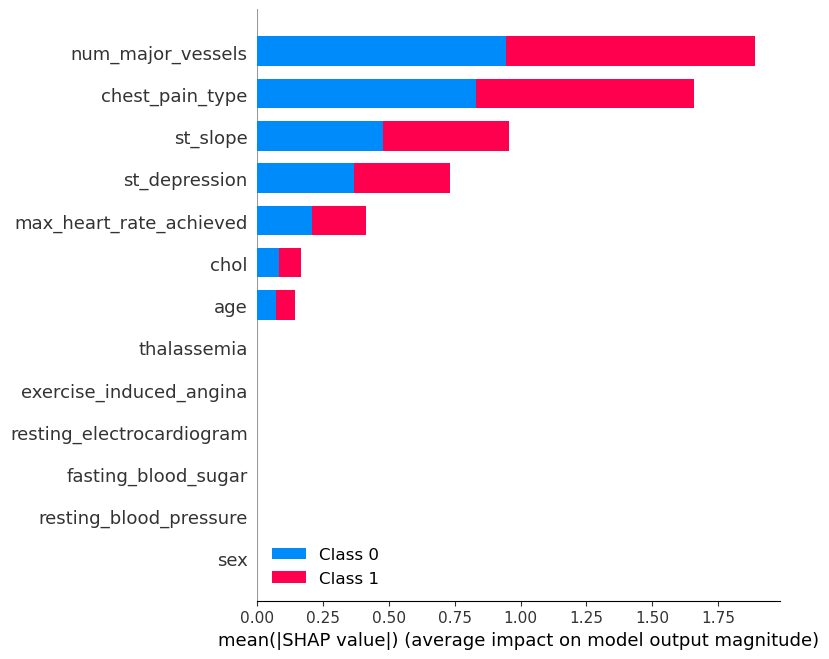

In [24]:
shap.initjs()
explainer = shap.TreeExplainer(lgbm)
shap_values = explainer.shap_values(X_val)
shap.summary_plot(shap_values, X_val, feature_names=features, plot_type="bar")

In [44]:
if isinstance(shap_values, list):
    shap_values = shap_values[1]
print(f"Explained expected value: {shap_values}")
                            

Explained expected value: .values =
array([[ 0.03753769,  0.        ,  0.58780137,  0.        , -0.08740461,
         0.        ,  0.        ,  0.19797951,  0.        , -0.32173061,
         0.5293115 ,  0.91939955,  0.        ],
       [ 0.0805792 ,  0.        ,  0.8037054 ,  0.        , -0.08740461,
         0.        ,  0.        ,  0.19797951,  0.        ,  0.40947532,
         0.5293115 , -1.03676971,  0.        ],
       [-0.08101724,  0.        ,  0.8037054 ,  0.        ,  0.08397698,
         0.        ,  0.        ,  0.19797951,  0.        , -0.32173061,
        -0.43307305,  0.91939955,  0.        ],
       [ 0.03753769,  0.        ,  0.58780137,  0.        ,  0.08397698,
         0.        ,  0.        ,  0.19797951,  0.        ,  0.40947532,
         0.5293115 ,  0.91939955,  0.        ],
       [ 0.03753769,  0.        ,  0.58780137,  0.        , -0.08740461,
         0.        ,  0.        , -0.22369595,  0.        ,  0.40947532,
         0.5293115 ,  0.91939955,  0.     

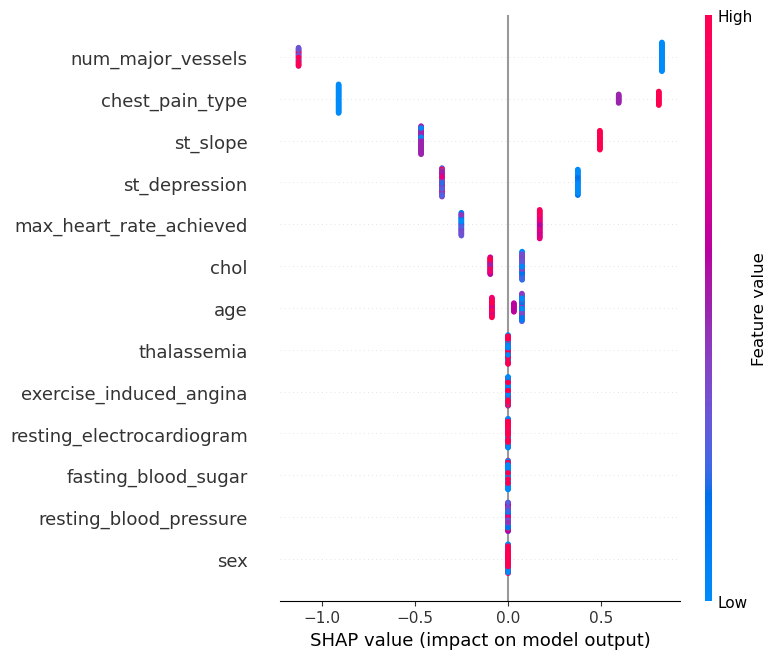

In [25]:
shap.summary_plot(shap_values[1], X_val)

In [36]:
explainer = shap.TreeExplainer(lgbm, data = X)
shap_values = explainer.shap_values(X_train)
shap.initjs()
shap.force_plot(explainer.expected_value, shap_values[0], feature_names = explainer.data_feature_names)

In [37]:
idx=1
shap.force_plot(explainer.expected_value, shap_values[idx,:], feature_names = explainer.data_feature_names)

In [38]:
dx=10
shap.force_plot(explainer.expected_value, shap_values[idx,:], feature_names = explainer.data_feature_names)

In [39]:
dx=100
shap.force_plot(explainer.expected_value, shap_values[idx,:], feature_names = explainer.data_feature_names)

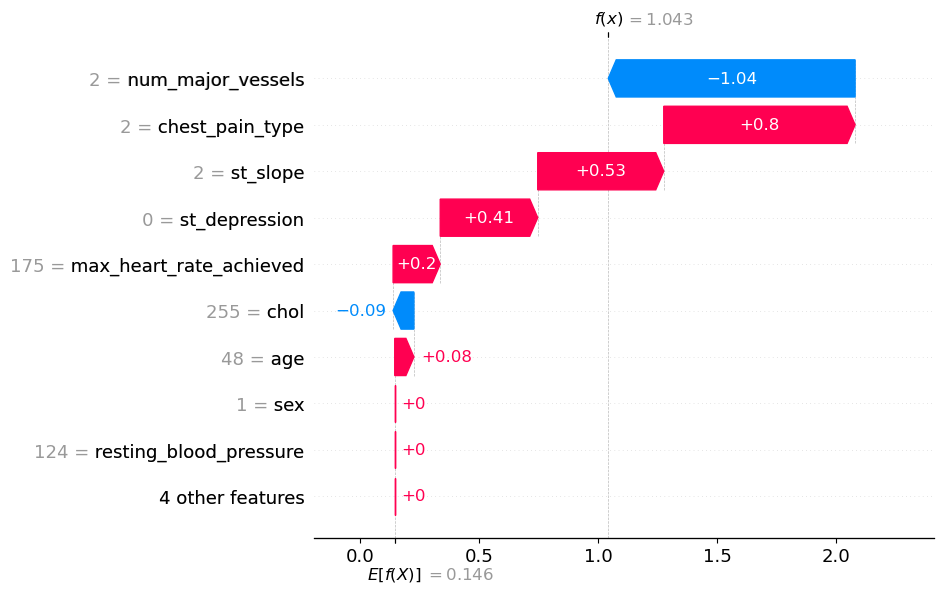

In [40]:
shap_values_one = explainer(X_train.iloc[idx:idx+1])
shap.plots.waterfall(shap_values_one[0])

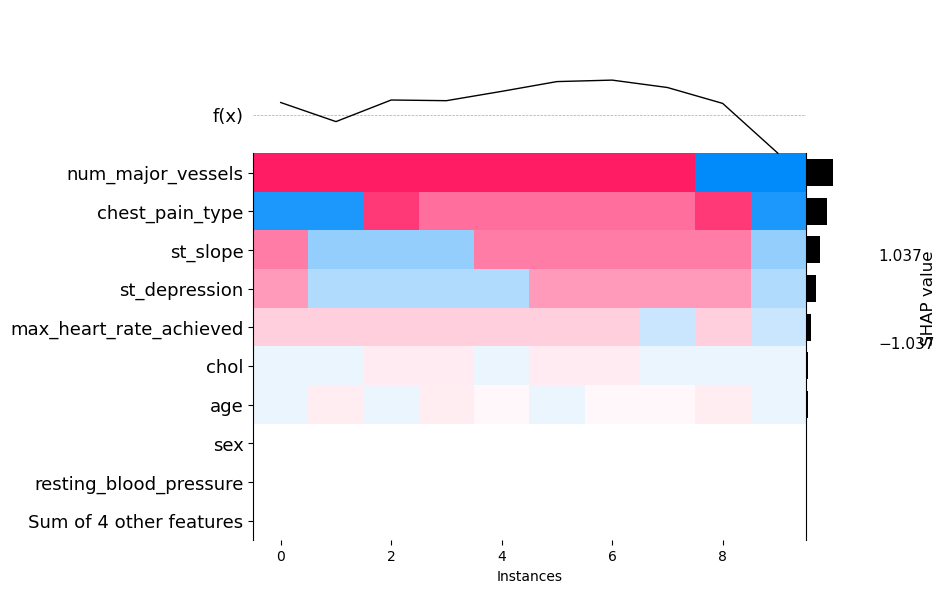

In [41]:
n = 10
shap_values = explainer(X_train.iloc[:n])
shap.plots.heatmap(shap_values)

In [42]:
shap.initjs()
shap_values_all = explainer.shap_values(X_train)

# visualize the first prediction's explanation  for many interpetations at the same time(use matplotlib=True to avoid Javascript)
shap.force_plot(explainer.expected_value, shap_values_all[:n], X_train.iloc[:n])

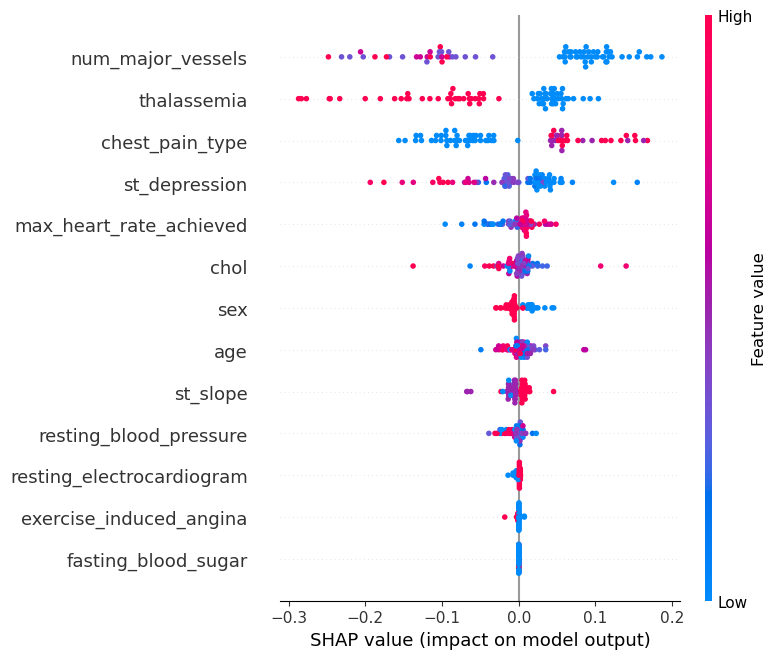

In [49]:
import xgboost
model = xgboost.train({'learning_rate': 0.01, 'random_state': 1},
                      xgboost.DMatrix(X_train, label=y_train), 100)
explainer = shap.TreeExplainer(model)
shap_values_all = explainer.shap_values(X_val)
shap.summary_plot(shap_values_all, X_val)

#### eli5 for LGTBM

In [52]:
import eli5
from eli5.sklearn import PermutationImportance

perm_imp = PermutationImportance(lgbm, random_state=seed).fit(X_train, y_train)
eli5.show_weights(perm_imp, feature_names = X_val.columns.tolist())

Weight,Feature
0.0928 ± 0.0167,num_major_vessels
0.0721 ± 0.0285,chest_pain_type
0.0306 ± 0.0371,st_slope
0.0054 ± 0.0184,max_heart_rate_achieved
0.0045 ± 0.0099,st_depression
0.0018 ± 0.0108,chol
0 ± 0.0000,thalassemia
0 ± 0.0000,exercise_induced_angina
0 ± 0.0000,resting_electrocardiogram
0 ± 0.0000,fasting_blood_sugar


####  eli5 for Xgboost

In [53]:
eli5.show_weights(model, feature_names=X_train.columns.tolist())

Weight,Feature
0.2873,num_major_vessels
0.2307,thalassemia
0.1439,chest_pain_type
0.0679,st_slope
0.0425,st_depression
0.0407,max_heart_rate_achieved
0.0377,resting_electrocardiogram
0.0364,chol
0.0314,age
0.0311,resting_blood_pressure


In [55]:
from eli5 import show_prediction

In [56]:
idx=100
show_prediction(model, X_train.iloc[idx], feature_names=X_train.columns.tolist(),
                show_feature_values=True)

In [57]:
from sklearn.tree import DecisionTreeClassifier

n = 100

tree_model = DecisionTreeClassifier(random_state=1)
tree_model.fit(X_train.iloc[:n], y_train[:n])

DecisionTreeClassifier(random_state=1)

In [58]:
from eli5.sklearn import explain_weights_sklearn
explanation = explain_weights_sklearn(tree_model, feature_names=X_train.columns.tolist())
type(explanation)

eli5.base.Explanation

In [60]:
from eli5.formatters import format_as_html
from IPython.display import HTML
html_rep = format_as_html(explanation)
HTML(data=html_rep)

Weight,Feature
0.4076,max_heart_rate_achieved
0.1435,st_depression
0.0931,chest_pain_type
0.0746,chol
0.0656,resting_blood_pressure
0.0497,sex
0.0489,thalassemia
0.0344,fasting_blood_sugar
0.0276,st_slope
0.0276,exercise_induced_angina


### Prediction with Lime

In [61]:
import lime.lime_tabular

In [62]:
explainer = lime.lime_tabular.LimeTabularExplainer(X_train.values, feature_names=X_train.columns.values.tolist(), class_names=y_train.unique())

In [63]:
idx = 0
exp = explainer.explain_instance(X_train.iloc[idx].values, tree_model.predict_proba, num_features=6)
exp.show_in_notebook(show_all=False)

### CONCLUSION

#### According to eli5 permutation importance, and SHAP, and Lime predictions
#### the three most important features of the model are
### 1. num_major_vessels, 
### 2. chest_pain_type, 
### 3. st_slope